# Demo Run

In [1]:
# %load_ext autoreload
# %autoreload 2
# # # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    import os
    import sys
    import gc
    import warnings
    import anndata as ad
    import scanpy as sc
    import copy
    import torch
    from pathlib import Path
    import networkx as nx
    from sklearn.neighbors import kneighbors_graph
    import numpy as np
    import rapids_singlecell as rsc
    import scanpy as sc
    import cupyx as cpx
    import pandas as pd
    import numpy as np
    import scipy.stats
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    import scib
    import scib_metrics
    
    sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
    import tardis
    tardis.config = tardis.config_server
    
    sc.settings.verbosity = 3
    
    print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [5]:
adata.X = adata.layers["counts"].copy()
del adata.layers
gc.collect()

1484

## Train

In [6]:
warmup_epoch_range = [12, 48]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=32, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=1000,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=True,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(adata, **model_params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    vae.train(**train_params)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_exploration_runs
ID: y9hexz4q
Name: still-elevator-26
Tags: tardis, exploration
Notes: Development runs for tardis.
URL: https://wandb.ai/inecik-academic/tardis_exploration_runs/runs/y9hexz4q
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240424_134254-y9hexz4q/files



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-bec14162-ba1e-5303-8edc-5be799b3d34e,MIG-5f262479-5840-557f-a3a2-990375d2e18b]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
SLURM auto-requeueing enabled. Setting signal hand

Epoch 1/1000:   0%|                                                                                                                      | 0/1000 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 229,379,431,195,390,300,538,140,458,364,435,366,244,284,42,197,457,281,278,530,241,265,153,48,331,137,106,279,100,86,190,191,51,338,240,170,275,139,97,185,369,454,323,984,146,376,178,196,277,317,226,136,387,276,266,370,310,642,290,302,233,585,237,147,251,355,281,729,357,366,267,372,368,363,123,237,235,152,62,124,199,501,306,270,346,208,156,237,370,176,143,102,263,407,156,153,445,76,145,291,176,370,105,244,175,223,321,129,142,283,276,113,117,354,350,356,261,46,49,219,216,271,77,187,305,257,186,238,268,221,957,273,197,529,301,148,496,349,498,467,209,464,473,280,358,245,358,227,277,292,268,241,252,417,388,248,254,188,147,604,245,239,147,152,175,171,525,259,379,209,280,423,619,402,293,275,232,238,172,170,209,189,195,254,611,350,332,351,370,7074,420,277,202,171,369,169,282,271,160,3

Epoch 1000/1000: 100%|█| 1000/1000 [2:16:45<00:00,  7.77s/it, v_num=4q_1, total_loss_train=1.17e+3, kl_local_train=27.4, tardis_condition_0_train=26.7, tardis_con

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|█| 1000/1000 [2:16:45<00:00,  8.21s/it, v_num=4q_1, total_loss_train=1.17e+3, kl_local_train=27.4, tardis_condition_0_train=26.7, tardis_con
W&B logger finalized successfully: 
Exit Code: 0



In [7]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "run13"
)

vae.save(
    dir_path,
    overwrite=False,
)

In [18]:
adata.obs

cov_drug_dose_name dose_val  control      condition  \
index                                                                         
AAACCTGAGAAGAAGC-1             A549_ctrl_1        1        1           ctrl   
AAACCTGAGGCATGTG-1   A549_TSC22D1+ctrl_1+1      1+1        0   TSC22D1+ctrl   
AAACCTGAGGCCCTTG-1    A549_KLF1+MAP2K6_1+1      1+1        0    KLF1+MAP2K6   
AAACCTGCACGAAGCA-1             A549_ctrl_1        1        1           ctrl   
AAACCTGCAGACGTAG-1  A549_CEBPE+RUNX1T1_1+1      1+1        0  CEBPE+RUNX1T1   
...                                    ...      ...      ...            ...   
TTTGTCATCAGTACGT-8     A549_FOXA3+ctrl_1+1      1+1        0     FOXA3+ctrl   
TTTGTCATCCACTCCA-8     A549_CELF2+ctrl_1+1      1+1        0     CELF2+ctrl   
TTTGTCATCCCAACGG-8    A549_BCORL1+ctrl_1+1      1+1        0    BCORL1+ctrl   
TTTGTCATCCTCCTAG-8  A549_ZBTB10+PTPN12_1+1      1+1        0  ZBTB10+PTPN12   
TTTGTCATCTGGCGAC-8    A549_MAP4K3+ctrl_1+1      1+1        0    MAP4K3+ctrl   

                                            guide_identity     drug_dose_name  \
index                                                                           
AAACCTGAGAAGAAGC-1    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0             ctrl_1   
AAACCTGAGGCATGTG-1      TSC22D1_NegCtrl0__TSC22D1_NegCtrl0   TSC22D1+ctrl_1+1   
AAACCTGAGGCCCTTG-1                KLF1_MAP2K6__KLF1_MAP2K6    KLF1+MAP2K6_1+1   
AAACCTGCACGAAGCA-1  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0             ctrl_1   
AAACCTGCAGACGTAG-1            CEBPE_RUNX1T1__CEBPE_RUNX1T1  CEBPE+RUNX1T1_1+1   
...                                                    ...                ...   
TTTGTCATCAGTACGT-8          FOXA3_NegCtrl0__FOXA3_NegCtrl0     FOXA3+ctrl_1+1   
TTTGTCATCCACTCCA-8          CELF2_NegCtrl0__CELF2_NegCtrl0     CELF2+ctrl_1+1   
TTTGTCATCCCAACGG-8        BCORL1_NegCtrl0__BCORL1_NegCtrl0    BCORL1+ctrl_1+1   
TTTGTCATCCTCCTAG-8            ZBTB10_PTPN12__ZBTB10_PTPN12  ZBTB10+PTPN12_1+1   
TTTGTCATCTGGCGAC-8        MAP4K3_NegCtrl0__MAP4K3_NegCtrl0    MAP4K3+ctrl_1+1   

                   cell_type  split split1 split2  ... split18 split19  \
index                                              ...                   
AAACCTGAGAAGAAGC-1      A549  train  train  train  ...   train   train   
AAACCTGAGGCATGTG-1      A549  train  train  train  ...   train   train   
AAACCTGAGGCCCTTG-1      A549  train  train  train  ...     ood     ood   
AAACCTGCACGAAGCA-1      A549  train   test  train  ...   train   train   
AAACCTGCAGACGTAG-1      A549  train  train  train  ...   train   train   
...                      ...    ...    ...    ...  ...     ...     ...   
TTTGTCATCAGTACGT-8      A549   test   test   test  ...    test   train   
TTTGTCATCCACTCCA-8      A549  train  train  train  ...   train    test   
TTTGTCATCCCAACGG-8      A549  train   test  train  ...   train   train   
TTTGTCATCCTCCTAG-8      A549  train  train  train  ...     ood   train   
TTTGTCATCTGGCGAC-8      A549  train  train   test  ...    test    test   

                   split20 split21 split22 split23 split24 split25  \
index                                                                
AAACCTGAGAAGAAGC-1   train   train   train   train   train   train   
AAACCTGAGGCATGTG-1   train   train   train   train   train   train   
AAACCTGAGGCCCTTG-1     ood   train   train     ood   train   train   
AAACCTGCACGAAGCA-1   train   train   train   train    test    test   
AAACCTGCAGACGTAG-1   train   train   train     ood   train   train   
...                    ...     ...     ...     ...     ...     ...   
TTTGTCATCAGTACGT-8   train   train    test   train   train   train   
TTTGTCATCCACTCCA-8   train   train   train   train   train   train   
TTTGTCATCCCAACGG-8   train   train   train   train   train   train   
TTTGTCATCCTCCTAG-8   train   train   train     ood   train   train   
TTTGTCATCTGGCGAC-8    test    test    test   train   train   train   

                   _scvi_batch _scvi_labels  
index                 

## Load Model

In [9]:
# dir_path = os.path.join(
#     tardis.config.io_directories["models"],
#     "run12"
# )
# vae12 = tardis.MyModel.load(dir_path, adata=adata)

## Check training

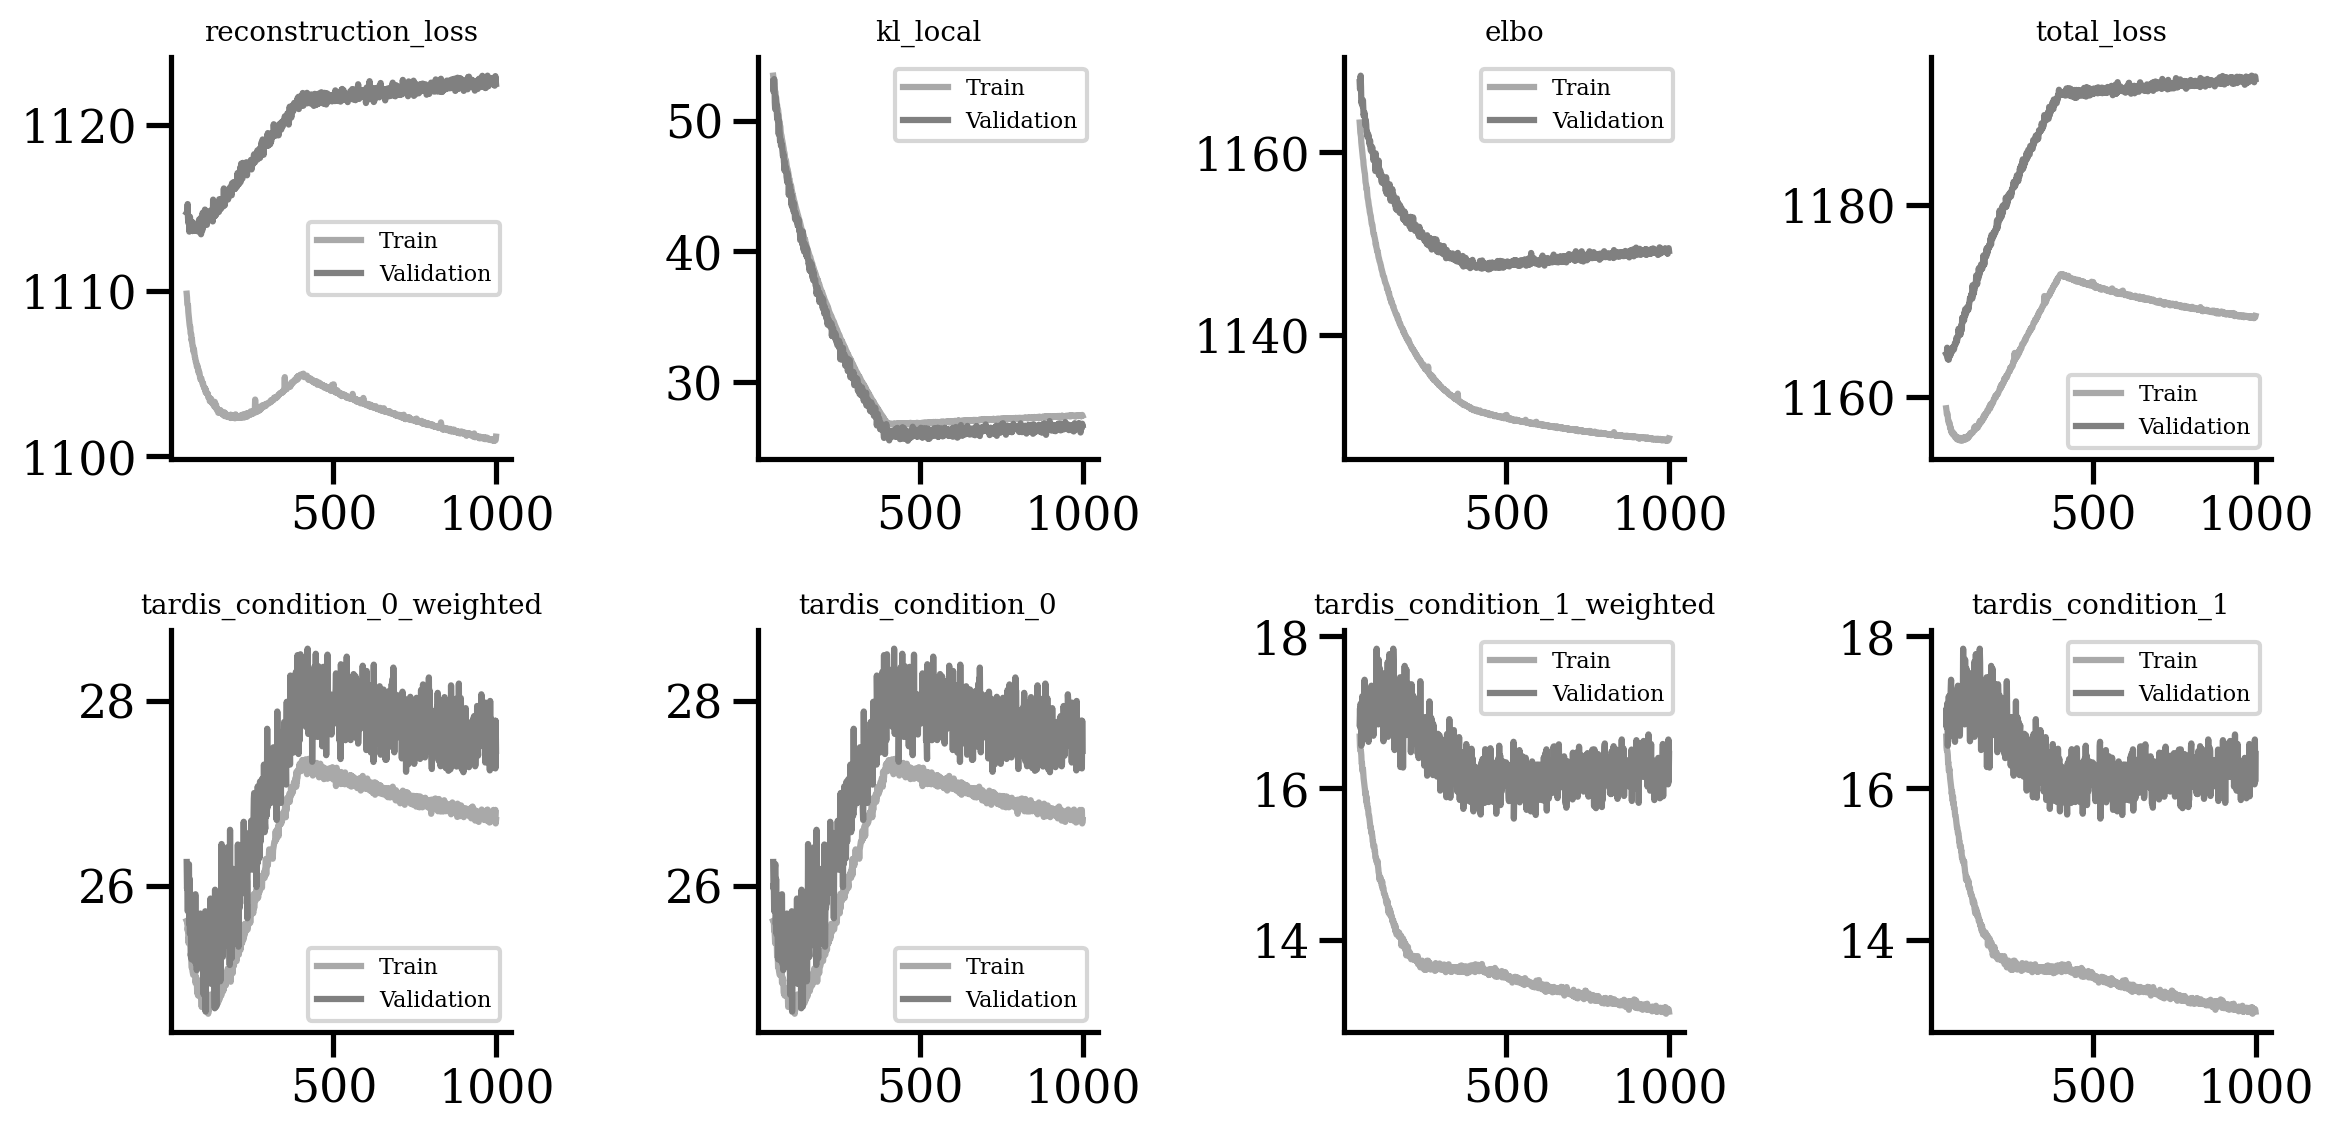

In [10]:
vae.plot_training_history(
    ignore_first=50, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        #
        "tardis_condition_0_weighted", 
        "tardis_condition_0",
        "tardis_condition_1_weighted", 
        "tardis_condition_1",
    ]
)

In [11]:
# from tardis._disentenglementtargetmanager import DisentenglementTargetManager
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices))
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("sex").reserved_latent_indices))

In [12]:
# vae.plot_latent_kde(
#     adata_obs=adata.obs,
#     target_obs_key="sex",
#     latent_representation=vae.get_latent_representation(),
#     latent_dim_of_interest=None
# )

# Metrics

In [13]:
batch_size_vae_metrics = 512
vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

reconstruction_error -1101.7059895665318
elbo -1128.928955078125
r2_train 0.9995674885655369
r2_validation 0.999580912317832


# Visualization

In [14]:
def prepare(ad_latent):
    sc.pp.neighbors(ad_latent, n_neighbors = 30)
    sc.tl.umap(ad_latent)

In [15]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
prepare(latent)
latent

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:37)


AnnData object with n_obs × n_vars = 108497 × 32
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

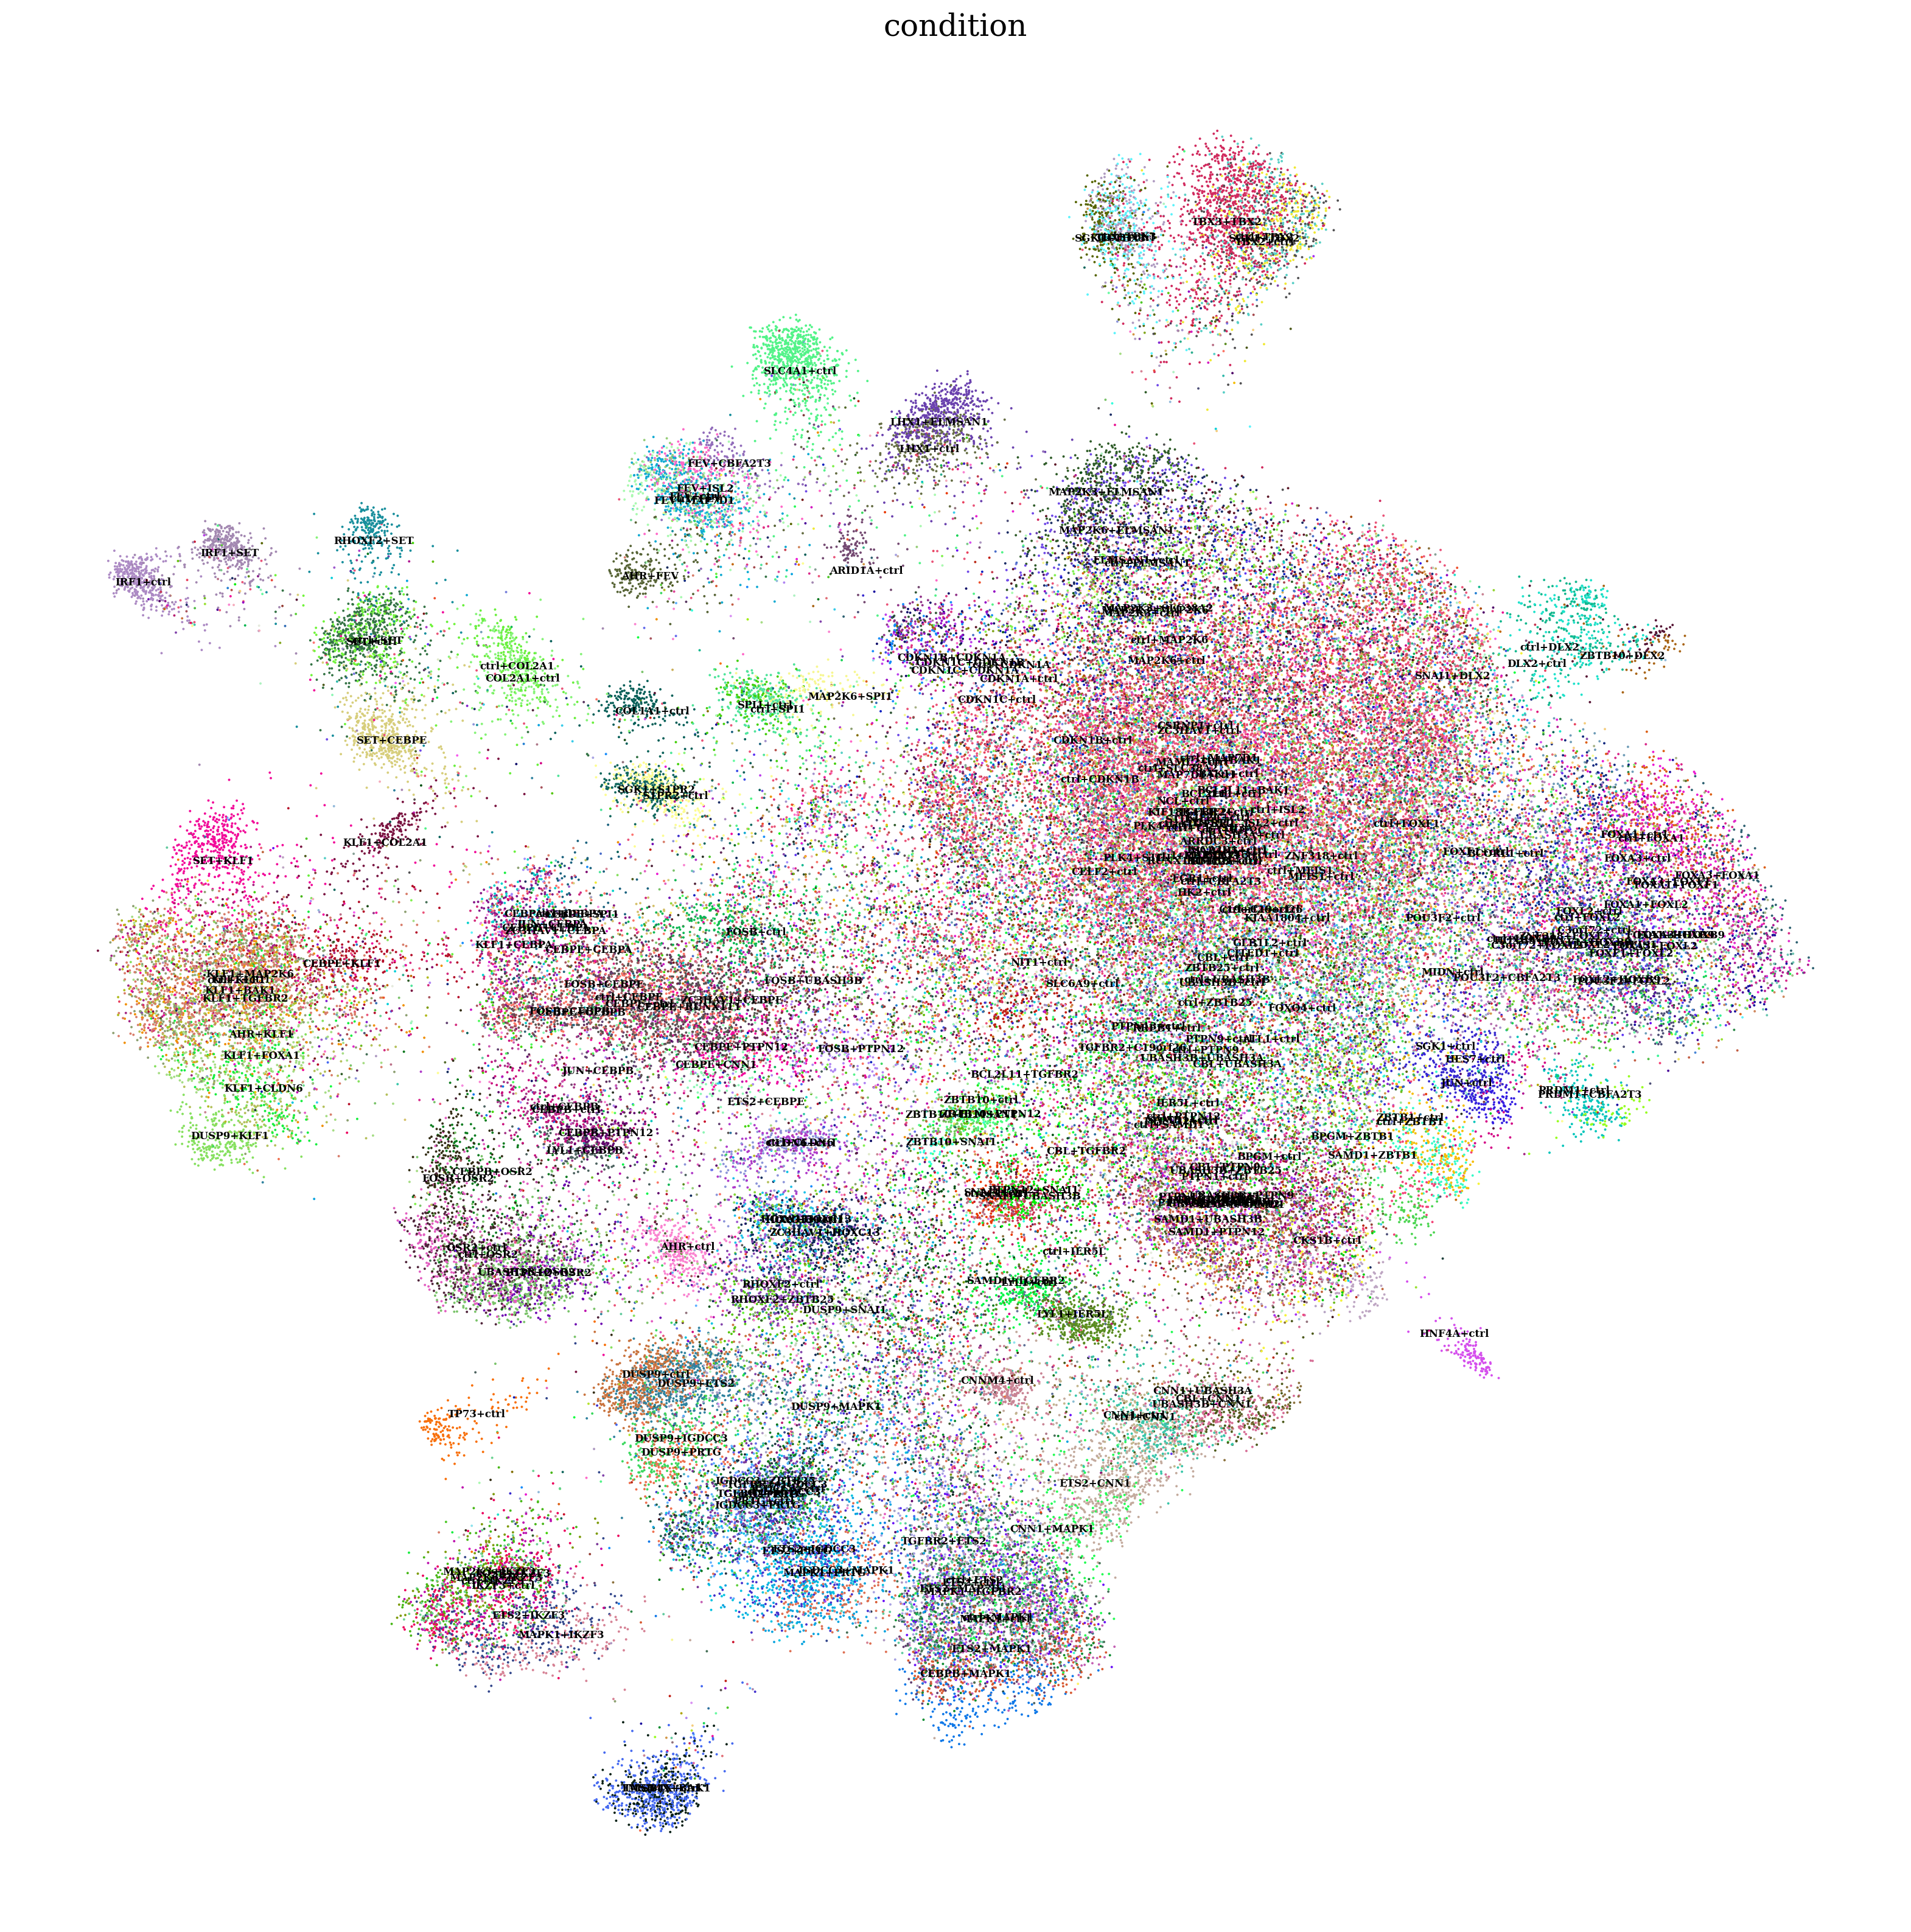

In [16]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = latent.obs["condition"].unique()
# Generate random colors for each unique cell type
random_colors = generate_random_colors(len(unique_cell_types))
# Create a dictionary to map cell types to colors
color_map = dict(zip(unique_cell_types, random_colors))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(20, 20))
    sc.pl.umap(
        latent, 
        color=["condition"], 
        ncols=1,
        size=8,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

In [17]:
del latent
gc.collect();